# DM1590 Final Project: Student Grade Prediction Model

# Authors
Linus Bälter, Matei Cananau, Alexander Diez Gonzalez, David Tanudin

### Background and motivation

Describe your problem and why it is interesting and important.

### Dataset

Describe what dataset you are using.

### Methodology

Describe what you are doing and how you are doing it.

---

In [51]:
# Present your work step-by-step with descriptions along the way, like in the laboratories.

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.metrics import f1_score


In [52]:
# Read in data from CSV-file
df = pd.read_csv('student-por.csv', sep=';')

# Print overview of DataFrame
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


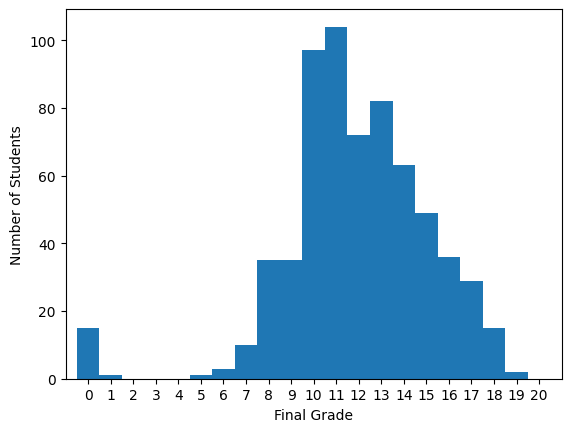

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
10%        8.800000
50%       12.000000
90%       16.000000
max       19.000000
Name: G3, dtype: float64

In [44]:
# Visualize final G3 grade distribution (0 to 20)
bins = np.arange(21) - 0.5
plt.hist(df['G3'], bins)
plt.xticks(range(21))
plt.xlim([-1, 21])
plt.xlabel('Final Grade')
plt.ylabel('Number of Students')
plt.show()

# Print descriptive statistics
df["G3"].describe(percentiles=[0.10, 0.5, 0.9])

# Supervised Learning (Naive Bayes Classifier from lab 5)

In [ ]:
# Redefine target column G3 as one of two classes, 0 for a score under the
# 90th-percentileof G3 grades and 1 for a score equal to or above it.


print("G3 values BEFORE redefinition")
print(df["G3"][0])
print(df["G3"][645])

for i in range(648+1):
    if df["G3"][i] < 16:  # If grade score is below 16, let this student's grade be represented as class 0.
        df["G3"][i] = 0
    else:
        df["G3"][i] = 1

print("G3 values AFTER redefinition")
print(df["G3"][0])
print(df["G3"][645])

#Remove warnings
import warnings
warnings.filterwarnings('ignore')


G3 values BEFORE redefinition
11
16
G3 values AFTER redefinition
0
1


/var/folders/kz/gmfk11mx34b1pg8svy4qw8340000gn/T/ipykernel_5267/2074443286.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["G3"][i] = 0
/var/folders/kz/gmfk11mx34b1pg8svy4qw8340000gn/T/ipykernel_5267/2074443286.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["G3"][i] = 1


Classifier *without* G1 and G2

In [46]:
# Prepare the dataset for training by dropping G1 and G2, encoding categorical columns and combining with the numerical columns.

# Specify which features are categorical and which are numerical
categorical_columns = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
numerical_columns = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences"]

# Drop G1 and G2 since we don't want to train the model on previous academic performance.
all_training_data = df.drop(["G2", "G1"],axis=1)

# Encode the categorical columns
training_data_encoded = pd.DataFrame()
for col in categorical_columns:
  LE = LabelEncoder()
  dt = LE.fit_transform(all_training_data[col])
  training_data_encoded[col] = dt

# Combine with the numerical columns
for col in numerical_columns:
  training_data_encoded[col] = all_training_data[col]

# Add in the encoded target column (G3)
LE = LabelEncoder()
training_data_encoded['G3'] = LE.fit_transform(all_training_data['G3'])


In [50]:
# Split data and train two Naive Bayes classifiers, one categorical and one numerical.

def split_train_pred():
    trainingSet, testSet = train_test_split(training_data_encoded, test_size=0.3)

    cnb = CategoricalNB(fit_prior=False)
    gnb = GaussianNB()

    cnb.fit(trainingSet.filter(categorical_columns, axis=1), trainingSet['G3'])
    logP_categorical = cnb.predict_log_proba(testSet.filter(categorical_columns, axis=1))

    gnb.fit(trainingSet.filter(numerical_columns, axis=1), trainingSet['G3'])
    logP_numerical = gnb.predict_log_proba(testSet.filter(numerical_columns, axis=1))
    
    # estimate prior
    probclass0 = np.sum(trainingSet['G3']==0)/len(trainingSet['G3'])

    logP = logP_categorical + logP_numerical + np.log([probclass0,1-probclass0])
    
    predictions = np.argmax(logP,axis=1)

    accuracy = sum(predictions==testSet['G3'])/testSet.shape[0]
    f1 = f1_score(testSet["G3"], predictions)

    return accuracy, f1

accuracies = []
sum_accuracies = 0

f1_scores = []
sum_f1 = 0

iterations = 1000
for i in range(iterations):
    acc, f1 = split_train_pred()
    accuracies.append(acc)
    sum_accuracies += acc

    f1_scores.append(f1)
    sum_f1 += f1

avg_accuracy = sum_accuracies/iterations
med_accuracy = accuracies[int(len(accuracies)/2)]
min_accuracy = min(accuracies)
max_accuracy = max(accuracies)
print(f"Average accuracy after {iterations} runs: {avg_accuracy}")
print(f"Median accuracy after {iterations} runs: {med_accuracy}")
print(f"Min accuracy after {iterations} runs: {min_accuracy}")
print(f"Max accuracy after {iterations} runs: {max_accuracy}")

avg_f1 = sum_f1/iterations
med_f1 = f1_scores[int(len(f1_scores)/2)]
min_f1 = min(f1_scores)
max_f1 = max(f1_scores)
print(f"Average F1-score after {iterations} runs: {avg_f1}")
print(f"Median F1-score after {iterations} runs: {med_f1}")
print(f"Min F1-score after {iterations} runs: {min_f1}")
print(f"Max F1-score after {iterations} runs: {max_f1}")


Average accuracy after 1000 runs: 0.6938615384615382
Median accuracy after 1000 runs: 0.8307692307692308
Min accuracy after 1000 runs: 0.28205128205128205
Max accuracy after 1000 runs: 0.8871794871794871
Average F1-score after 1000 runs: 0.2934224565997909
Median F1-score after 1000 runs: 0.29787234042553196
Min F1-score after 1000 runs: 0.09090909090909093
Max F1-score after 1000 runs: 0.5217391304347826


Classifier *with* G1 and G2

In [62]:
# Recreate original variables

# Read in data from CSV-file
df = pd.read_csv('student-por.csv', sep=';')

# Redefine target column G3 as one of two classes, 0 for a score under the
# 90th-percentileof G3 grades and 1 for a score equal to or above it.

print("G3 values BEFORE redefinition")
print(df["G3"][0])
print(df["G3"][645])

for i in range(648+1):
    if df["G3"][i] < 16:  # If grade score is below 16, let this student's grade be represented as class 0.
        df["G3"][i] = 0
    else:
        df["G3"][i] = 1

print("G3 values AFTER redefinition")
print(df["G3"][0])
print(df["G3"][645])

G3 values BEFORE redefinition
11
16
G3 values AFTER redefinition
0
1


/var/folders/kz/gmfk11mx34b1pg8svy4qw8340000gn/T/ipykernel_5267/2438713741.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["G3"][i] = 0
/var/folders/kz/gmfk11mx34b1pg8svy4qw8340000gn/T/ipykernel_5267/2438713741.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["G3"][i] = 1


In [65]:
# Prepare the dataset for training by dropping G1 and G2, encoding categorical columns and combining with the numerical columns.

# Specify which features are categorical and which are numerical
categorical_columns = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
numerical_columns = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2"]

all_training_data = df

# Encode the categorical columns
training_data_encoded = pd.DataFrame()
for col in categorical_columns:
  LE = LabelEncoder()
  dt = LE.fit_transform(all_training_data[col])
  training_data_encoded[col] = dt

# Combine with the numerical columns
for col in numerical_columns:
  training_data_encoded[col] = all_training_data[col]

# Add in the encoded target column (G3)
LE = LabelEncoder()
training_data_encoded['G3'] = LE.fit_transform(all_training_data['G3'])


In [66]:
# Split data and train two Naive Bayes classifiers, one categorical and one numerical.

def split_train_pred():
    trainingSet, testSet = train_test_split(training_data_encoded, test_size=0.3)

    cnb = CategoricalNB(fit_prior=False)
    gnb = GaussianNB()

    cnb.fit(trainingSet.filter(categorical_columns, axis=1), trainingSet['G3'])
    logP_categorical = cnb.predict_log_proba(testSet.filter(categorical_columns, axis=1))

    gnb.fit(trainingSet.filter(numerical_columns, axis=1), trainingSet['G3'])
    logP_numerical = gnb.predict_log_proba(testSet.filter(numerical_columns, axis=1))
    
    # estimate prior
    probclass0 = np.sum(trainingSet['G3']==0)/len(trainingSet['G3'])

    logP = logP_categorical + logP_numerical + np.log([probclass0,1-probclass0])
    
    predictions = np.argmax(logP,axis=1)

    accuracy = sum(predictions==testSet['G3'])/testSet.shape[0]
    f1 = f1_score(testSet["G3"], predictions)

    return accuracy, f1

accuracies = []
sum_accuracies = 0

f1_scores = []
sum_f1 = 0

iterations = 1000
for i in range(iterations):
    acc, f1 = split_train_pred()
    accuracies.append(acc)
    sum_accuracies += acc

    f1_scores.append(f1)
    sum_f1 += f1

avg_accuracy = sum_accuracies/iterations
med_accuracy = accuracies[int(len(accuracies)/2)]
min_accuracy = min(accuracies)
max_accuracy = max(accuracies)
print(f"Average accuracy after {iterations} runs: {avg_accuracy}")
print(f"Median accuracy after {iterations} runs: {med_accuracy}")
print(f"Min accuracy after {iterations} runs: {min_accuracy}")
print(f"Max accuracy after {iterations} runs: {max_accuracy}")

avg_f1 = sum_f1/iterations
med_f1 = f1_scores[int(len(f1_scores)/2)]
min_f1 = min(f1_scores)
max_f1 = max(f1_scores)
print(f"Average F1-score after {iterations} runs: {avg_f1}")
print(f"Median F1-score after {iterations} runs: {med_f1}")
print(f"Min F1-score after {iterations} runs: {min_f1}")
print(f"Max F1-score after {iterations} runs: {max_f1}")


Average accuracy after 1000 runs: 0.8815641025640986
Median accuracy after 1000 runs: 0.8153846153846154
Min accuracy after 1000 runs: 0.676923076923077
Max accuracy after 1000 runs: 0.9846153846153847
Average F1-score after 1000 runs: 0.6836374128970302
Median F1-score after 1000 runs: 0.5135135135135135
Min F1-score after 1000 runs: 0.33333333333333337
Max F1-score after 1000 runs: 0.9433962264150944


---
# Discussion



## Acknowledgments

For each group member, describe what they did.

## Final meme

Include here a meme describing your experience in this module.